<a href="https://colab.research.google.com/github/EdsonGiannini/Trabalho-da-Sprint-de-Machine-Learning-Analytics/blob/main/MVP_EDSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#MVP: *Machine Learning & Analytics*
**Autor:** _Edson Giannini Ferreira_  

**Data:** 09/09/2025

**Matrícula:** 4052025000128

**Dataset:**: [Desempenho de alunos](https://www.kaggle.com/datasets/thiagopedropadilha/desempenho-de-alunos)


## 1. Escopo, objetivo e definição do problema
  O projeto pretende tentar prever a nota de alunos baseando-se na idade e no tempo de estudo dos mesmos.
- Tipo de tarefa: **Regressão**.
- Área de aplicação: **Dados tabulares**.


## 2. Reprodutibilidade e ambiente

In [16]:
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score # Import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


### 2.2 Funções python (opcional)
Defina, se necessário, funções em Python para reutilizar seu código e torná-lo mais organizado. Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.

In [17]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}

def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def evaluate_clustering(X_original, model):
    # Silhouette requer >1 cluster e dados transformados
    try:
        if hasattr(model.named_steps["pre"], "transform"):
            X_emb = model.named_steps["pre"].fit_transform(X_original)  # cuidado: apenas para demo
        else:
            X_emb = X_original
        labels = model.named_steps["model"].fit_predict(X_emb)
        sil = silhouette_score(X_emb, labels)
        return {"silhouette": sil}
    except Exception as e:
        return {"silhouette": np.nan, "erro": str(e)}


## 3. Dados: carga, entendimento e qualidade

In [18]:
df = pd.read_csv("https://raw.githubusercontent.com/EdsonGiannini/Trabalho-da-Sprint-de-Machine-Learning-Analytics/refs/heads/main/desempenho_alunos_dataset.csv")

df


,ID_Aluno,Idade,Horas_Estudo_Semana,Pontuacao_Prova_Final,Aprovado
0,1,23,7,16,False
1,2,22,23,63,True
2,3,18,10,33,False
3,4,21,17,33,False
4,5,21,27,76,True
...,...,...,...,...,...
11995,11996,24,15,28,False
11996,11997,21,28,62,True
11997,11998,23,29,67,True
11998,11999,18,12,38,False


# Limpeza e pré-processamento de Dados

In [19]:
#Retidrando colunas não usadas
del df['ID_Aluno']
del df['Aprovado']

#Procurando linhas com dados faltantes
df[df.isnull().any(axis=1)]

,Idade,Horas_Estudo_Semana,Pontuacao_Prova_Final


# **Verificações iniciais**

In [20]:
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,Idade,Horas_Estudo_Semana,Pontuacao_Prova_Final
1935,22,16,39
6494,19,26,61
1720,22,7,10
9120,22,36,89
360,18,13,27



Formato: (12000, 3)

Tipos:
Idade                    int64
Horas_Estudo_Semana      int64
Pontuacao_Prova_Final    int64
dtype: object

Valores ausentes por coluna:
Idade                    0
Horas_Estudo_Semana      0
Pontuacao_Prova_Final    0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)
**TODO:** inclua gráficos e tabelas essenciais para entender o problema e levantar hipóteses.  
Evite EDA muito extensa — foque no que afeta as decisões de modelagem.


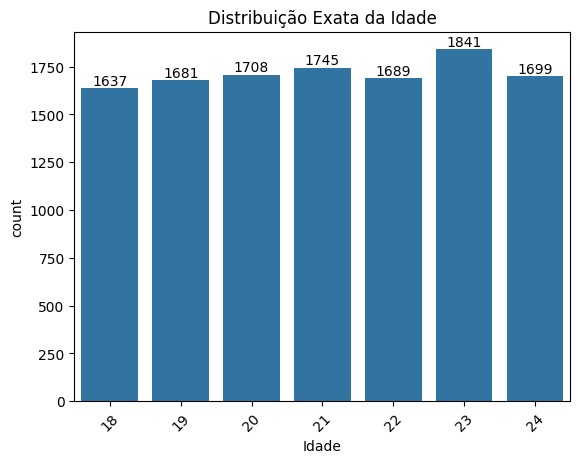

In [21]:
ax = sns.countplot(data=df, x='Idade')
plt.title('Distribuição Exata da Idade')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()


In [22]:
# Tabela com múltiplas estatísticas
tabela_detalhada = df.groupby('Horas_Estudo_Semana')['Pontuacao_Prova_Final'].agg([
    ('Média', 'mean'),
    ('Mediana', 'median'),
    ('Desvio_Padrão', 'std'),
    ('Mínimo', 'min'),
    ('Máximo', 'max'),
]).round(2).reset_index()

print(tabela_detalhada)

    Horas_Estudo_Semana  Média  Mediana  Desvio_Padrão  Mínimo  Máximo
0                     5  12.95     13.0           5.76       3      22
1                     6  14.59     14.0           5.71       5      25
2                     7  17.55     17.0           5.72       8      27
3                     8  19.79     19.0           5.52      10      30
4                     9  22.14     22.0           5.65      13      32
5                    10  24.83     25.0           5.59      15      35
6                    11  27.65     28.0           5.79      18      37
7                    12  30.07     30.0           5.92      20      40
8                    13  32.61     33.0           5.82      23      42
9                    14  35.21     35.0           5.71      25      45
10                   15  37.80     38.0           5.83      28      47
11                   16  39.65     40.0           5.73      30      50
12                   17  41.95     41.0           5.51      33      52
13    


## 4. Definição do target, variáveis e divisão dos dados
**TODO:** escolha o **target** (ou defina a tarefa de clusterização/forecast).  
- Em **séries temporais**, **não embaralhe** e use divisões temporais (ex.: `TimeSeriesSplit`).
- Em **classificação desequilibrada**, considere **estratégias para desbalanceamento** (ex.: `class_weight`, undersampling/oversampling).

> **Atenção:** Todas as **transformações** aprendidas devem ser **ajustadas no treino** e **aplicadas no validação/teste**. Recomendamos usar **pipelines**.


In [23]:
# Selecione o tipo de problema: 'classificacao' | 'regressao' | 'clusterizacao' | 'serie_temporal'
PROBLEM_TYPE = "regressao"  # TODO: ajuste

# Defina features e target conforme o problema
if PROBLEM_TYPE == "classificacao":
    target = "target_clf"
    features = [c for c in df.columns if c not in [target, "timestamp"]]
elif PROBLEM_TYPE == "regressao":
    target = "Pontuacao_Prova_Final" # Corrected target name
    features = [c for c in df.columns if c not in [target, "timestamp"]]
elif PROBLEM_TYPE == "clusterizacao":
    target = None
    features = [c for c in df.columns if c not in ["target_clf","target_reg","timestamp"]]
elif PROBLEM_TYPE == "serie_temporal":
    target = "target_reg"  # Exemplo
    features = [c for c in df.columns if c not in [target]]
else:
    raise ValueError("PROBLEM_TYPE inválido.")

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# Divisão dos dados
if PROBLEM_TYPE in ["classificacao", "regressao"]:
    X = df[features].copy()
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y if PROBLEM_TYPE=="classificacao" else None
    )
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)
elif PROBLEM_TYPE == "clusterizacao":
    X = df[features].copy()
    # Sem target — você pode reservar um hold-out para avaliação externa se fizer sentido de negócio.
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=SEED)
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)
elif PROBLEM_TYPE == "serie_temporal":
    # Ordenar por tempo e criar cortes temporais (exemplo simples hold-out temporal)
    df_sorted = df.sort_values("timestamp")
    cutoff = int(len(df_sorted)*0.8)
    train, test = df_sorted.iloc[:cutoff], df_sorted.iloc[cutoff:]
    X_train, y_train = train.drop(columns=[target]), train[target]
    X_test, y_test   = test.drop(columns=[target]),  test[target]
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)

PROBLEM_TYPE: regressao
Target: Pontuacao_Prova_Final
N features: 2
Treino: (9600, 2) | Teste: (2400, 2)



## 5. Tratamento de dados e **Pipeline** de pré-processamento
Crie um **Pipeline** com as etapas necessárias (limpeza, imputação, encoding, escala, seleção de atributos, etc.)  
Isso garante **reprodutibilidade** e evita **vazamento**.


In [24]:
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols and c != "timestamp"]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

print("num_cols:", num_cols[:5], "...")
print("cat_cols:", cat_cols[:5], "...")

num_cols: ['Idade', 'Horas_Estudo_Semana'] ...
cat_cols: [] ...



## 6. Baseline e modelos candidatos
Se possivek, comece com uma **baseline simples** (ex.: DummyClassifier/Regressor) e evolua para modelos mais fortes. O baseline pode ser seu primeiro modelo!  

**Compare** ao menos **duas abordagens**.

> Para **deep learning** (visão computacional/NLP/séries), crie uma seção específica (p. ex., `TensorFlow`/`PyTorch`) e documente arquitetura, parâmetros e tempo de treino.


In [25]:
# === Baselines ===
if PROBLEM_TYPE == "classificacao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))])
    candidates = {
        "LogisticRegression": Pipeline([("pre", preprocess), ("model", LogisticRegression(max_iter=200, random_state=SEED))]),
        "RandomForest": Pipeline([("pre", preprocess), ("model", RandomForestClassifier(random_state=SEED))])
    }
elif PROBLEM_TYPE == "regressao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyRegressor(strategy="median"))])
    candidates = {
        "Ridge": Pipeline([("pre", preprocess), ("model", Ridge(random_state=SEED))]),
        "RandomForestReg": Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    }
elif PROBLEM_TYPE == "clusterizacao":
    # baseline não se aplica diretamente; use um método simples (ex.: KMeans com k fixo) como referência.
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", KMeans(n_clusters=3, random_state=SEED))])
    candidates = {
        "KMeans_k3": Pipeline([("pre", preprocess), ("model", KMeans(n_clusters=3, random_state=SEED))]),
        "KMeans_k5": Pipeline([("pre", preprocess), ("model", KMeans(n_clusters=5, random_state=SEED))])
    }
elif PROBLEM_TYPE == "serie_temporal":
    # Em séries temporais, a baseline pode ser "naive" (último valor) — aqui, apenas um placeholder.
    # Para modelos clássicos, pode considerar por exemplo Regressores com janelas (feature engineering temporal).
    baseline = None
    candidates = {}
else:
    raise ValueError("PROBLEM_TYPE inválido.")

baseline


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Idade',
                                                   'Horas_Estudo_Semana']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('model', DummyRegressor(strategy='median'))])


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Use **métricas adequadas** ao tipo de problema. Documente suas observações.


In [26]:
results = {}

if PROBLEM_TYPE in ["classificacao", "regressao"]:
    # Baseline
    t0 = time.time()
    baseline.fit(X_train, y_train)
    t1 = time.time()
    if PROBLEM_TYPE == "classificacao":
        y_pred = baseline.predict(X_test)
        proba = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
        results["baseline"] = evaluate_classification(y_test, y_pred, proba)
    else:
        y_pred = baseline.predict(X_test)
        results["baseline"] = evaluate_regression(y_test, y_pred)
    results["baseline"]["train_time_s"] = round(t1 - t0, 3)

    # Candidatos
    for name, pipe in candidates.items():
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()
        if PROBLEM_TYPE == "classificacao":
            y_pred = pipe.predict(X_test)
            proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
            results[name] = evaluate_classification(y_test, y_pred, proba)
        else:
            y_pred = pipe.predict(X_test)
            results[name] = evaluate_regression(y_test, y_pred)
        results[name]["train_time_s"] = round(t1 - t0, 3)

elif PROBLEM_TYPE == "clusterizacao":
    # Baseline e candidatos (ex.: silhouette)
    # Observação: em um projeto real, evite refit em dados de teste fora de validação apropriada.
    results["baseline"] = evaluate_clustering(X_test, baseline)
    for name, pipe in candidates.items():
        results[name] = evaluate_clustering(X_test, pipe)

elif PROBLEM_TYPE == "serie_temporal":
    # TODO: implemente métricas específicas (ex.: MAE/MAPE/RMSE out-of-time)
    results["baseline_naive"] = {"MAE": None, "MAPE": None, "RMSE": None, "obs": "Implementar baseline temporal."}

pd.DataFrame(results).T


,MAE,RMSE,R2,train_time_s
baseline,22.437083,26.072615,-0.001733,0.011
Ridge,5.012752,5.775016,0.950854,0.011
RandomForestReg,5.043629,5.822017,0.950051,0.480



## 7. Validação e Otimização de Hiperparâmetros
Use **validação cruzada** apropriada ao problema (Ex: **`StratifiedKFold`** para classificação; **`KFold`** para regressão).  
Faça **tuning** com `GridSearchCV`/`RandomizedSearchCV`.


In [27]:
if PROBLEM_TYPE == "classificacao":
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model = Pipeline([("pre", preprocess), ("model", RandomForestClassifier(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    }
    scorer = "f1_weighted"

elif PROBLEM_TYPE == "regressao":
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    }
    scorer = "neg_root_mean_squared_error"

elif PROBLEM_TYPE == "clusterizacao":
    # Clusterização: tuning diferente (ex.: número de clusters). Métricas internas (silhouette) ou externas (se houver rótulos).
    cv = None
    model = Pipeline([("pre", preprocess), ("model", KMeans(random_state=SEED))])
    param_dist = {"model__n_clusters": randint(2, 10)}
    scorer = None

elif PROBLEM_TYPE == "serie_temporal":
    cv = TimeSeriesSplit(n_splits=5)
    # Ex.: usar um regressor com janelas/defasagens previamente criadas
    model = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))])
    param_dist = {
        "model__n_estimators": randint(100, 300),
        "model__max_depth": randint(3, 15)
    }
    scorer = "neg_mean_absolute_error"

# Executar busca aleatória (exemplo geral — ajuste para seu caso)
if PROBLEM_TYPE != "clusterizacao":
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)
    print("Melhor score (CV):", search.best_score_)
    print("Melhores parâmetros:", search.best_params_)
else:
    print("Para clusterização, avalie k em um range e compare silhouette/indíces de validade. Ex.: varra k de 2 a 10.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): -5.7256814791283315
Melhores parâmetros: {'model__max_depth': 5, 'model__min_samples_split': 7, 'model__n_estimators': 357}



## 8. Avaliação final, análise de erros e limitações
- **Compare** baseline vs melhor modelo.  
- Faça **análise de erros** (ex.: matriz de confusão, casos pior previstos, resíduos).  
- Discuta **limitações**: dados, métricas, viés, generalização.


In [28]:
# Exemplo de re-treino no conjunto de treino+validação (se aplicável) e avaliação no teste

if PROBLEM_TYPE in ["classificacao", "regressao"] and 'search' in globals() and hasattr(search, "best_estimator_"):
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    if PROBLEM_TYPE == "classificacao":
        from sklearn.metrics import classification_report, ConfusionMatrixDisplay
        print(classification_report(y_test, y_pred))
        try:
            ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
            plt.title("Matriz de confusão - Melhor modelo")
            plt.show()
        except Exception as e:
            print("Não foi possível plotar a matriz de confusão:", e)
    else:
        print('Metricas para avaliar a regressão: ', evaluate_regression(y_test, y_pred))
elif PROBLEM_TYPE == "clusterizacao":
    print("Realize análise qualitativa/negócio dos clusters. Visualize centros e perfis.")
elif PROBLEM_TYPE == "serie_temporal":
    print("Avalie métricas fora do tempo; plote série real vs prevista.")

Metricas para avaliar a regressão:  {'MAE': 5.033883025866322, 'RMSE': np.float64(5.801502238861488), 'R2': 0.9504020280585682}



## 9. Engenharia de atributos (detalhe)
**TODO:** Documente as escolhas: seleção/extração, encoding, criação de variáveis temporais (lags, médias móveis), TF-IDF/embeddings (NLP), augmentations (visão), etc.



## 10. (Opcional) Deep Learning / Fine-tuning
Se usar DL, descreva: arquitetura, hiperparâmetros, _early stopping_, tamanho do batch, épocas, e se houve **fine-tuning** de modelos pré-treinados.



## 11. Boas práticas e rastreabilidade
- **Baseline** claro e justificativas para melhorias.  
- **Pipelines** (evitar vazamento).  
- **Decisões de projeto** documentadas (o que tentou e por quê).



## 12. Conclusões e próximos passos
**TODO:** Resuma resultados, trade-offs, e proponha melhorias futuras (mais dados, features, modelos, tuning).



## 13. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  